In [20]:
import torch
from transformers import BertModel, pipeline
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
sd_hf = model.state_dict()

In [6]:
for k,v in sd_hf.items():
    print(k, v.shape)

embeddings.word_embeddings.weight torch.Size([30522, 768])
embeddings.position_embeddings.weight torch.Size([512, 768])
embeddings.token_type_embeddings.weight torch.Size([2, 768])
embeddings.LayerNorm.weight torch.Size([768])
embeddings.LayerNorm.bias torch.Size([768])
encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
encoder.layer.0.attention.self.query.bias torch.Size([768])
encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
encoder.layer.0.attention.self.key.bias torch.Size([768])
encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
encoder.layer.0.attention.self.value.bias torch.Size([768])
encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
encoder.layer.0.attention.output.dense.bias torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
encoder.layer.0.inter

In [13]:
# The vocabulary size used with BERT
sd_hf["embeddings.word_embeddings.weight"].shape[0]

30522

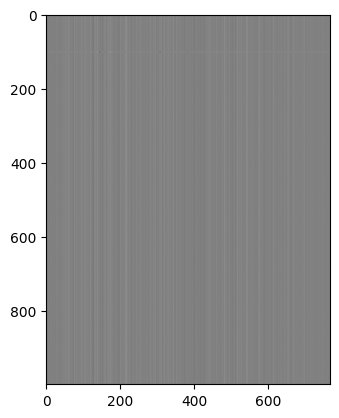

In [16]:
plt.imshow(sd_hf["embeddings.word_embeddings.weight"][:1000], cmap="gray")
plt.show()

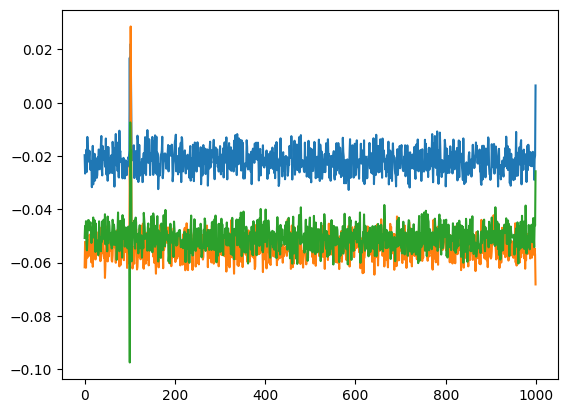

In [17]:
plt.plot(sd_hf["embeddings.word_embeddings.weight"][:1000, 150])
plt.plot(sd_hf["embeddings.word_embeddings.weight"][:1000, 200])
plt.plot(sd_hf["embeddings.word_embeddings.weight"][:1000, 250])
plt.show()

In [18]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [26]:
# fill mask
# https://huggingface.co/tasks/fill-mask
device = "cuda:1"
classifier = pipeline("fill-mask", model = "bert-base-uncased", device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:1


In [28]:
classifier.tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [29]:
classifier("Paris is the [MASK] of France")

[{'score': 0.9975810050964355,
  'token': 3007,
  'token_str': 'capital',
  'sequence': 'paris is the capital of france'},
 {'score': 0.0004168376908637583,
  'token': 2415,
  'token_str': 'center',
  'sequence': 'paris is the center of france'},
 {'score': 0.00034646783024072647,
  'token': 2103,
  'token_str': 'city',
  'sequence': 'paris is the city of france'},
 {'score': 0.00030852979398332536,
  'token': 2540,
  'token_str': 'heart',
  'sequence': 'paris is the heart of france'},
 {'score': 0.0002590009244158864,
  'token': 2803,
  'token_str': 'centre',
  'sequence': 'paris is the centre of france'}]

In [31]:
import sentencepiece as spm